## Pre-select cases with all sequences and save them into a separate folder ##

In [12]:
import os
import shutil
import nibabel as nib
# Uncomment the next line if visualization is needed
# import matplotlib.pyplot as plt
import numpy as np

def load_nifti(file_path):
    """Load a NIfTI file and return the image data and voxel dimensions."""
    nifti_img = nib.load(file_path)
    return nifti_img.get_fdata(), nifti_img.header.get_zooms()

def plot_mri_slices(img, voxel_dims, title, axes):
    """Plot middle slices in sagittal, coronal, and axial orientations."""
    middle_slices = [img.shape[i] // 2 for i in range(3)]
    # Sagittal
    sagittal_slice = img[middle_slices[0], :, :]
    axes.imshow(sagittal_slice, cmap='gray', origin='lower', aspect=voxel_dims[1]/voxel_dims[2])
    axes.set_title(f'{title}')
    axes.axis('off')

def ensure_dir_exists(directory):
    """Ensure that a directory exists; if not, it is created."""
    if not os.path.exists(directory):
        os.makedirs(directory)

# Path to the dataset root
root_dir = '/Users/shangke/Desktop/nii'
# Destination directory for complete cases
destination_dir = '/Users/shangke/Desktop/complete_cases'

# Ensure the destination directory exists
ensure_dir_exists(destination_dir)

# Counters for complete and incomplete cases
complete_cases_count = 0
incomplete_cases = []

# Iterate through each case folder
for patient_id in os.listdir(root_dir):
    patient_folder = os.path.join(root_dir, patient_id)
    if not os.path.isdir(patient_folder):
        continue  # Skip non-directory files
    
    # Initialize file paths
    t1_post_file = t1_pre_file = t2_file = flair_file = None

    # Search for T1, T1_pre, T2, and FLAIR files with specific names
    for file in os.listdir(patient_folder):
        if file == 'AX-3D-T1-POST.nii':
            t1_post_file = os.path.join(patient_folder, file)
        elif file == 'AX-3D-T1-PRE.nii':
            t1_pre_file = os.path.join(patient_folder, file)
        elif file == 'AX-T2.nii':
            t2_file = os.path.join(patient_folder, file)
        elif file == 'AX-FLAIR.nii':
            flair_file = os.path.join(patient_folder, file)

    # Check if all the files are found
    if t1_post_file and t1_pre_file and t2_file and flair_file:
        complete_cases_count += 1

        # Load the NIfTI files
        t1_post_img, t1_post_voxel_dims = load_nifti(t1_post_file)
        t1_pre_img, t1_pre_voxel_dims = load_nifti(t1_pre_file)
        t2_img, t2_voxel_dims = load_nifti(t2_file)
        flair_img, flair_voxel_dims = load_nifti(flair_file)

        # Uncomment below code to enable plotting
        # fig, axes = plt.subplots(1, 4, figsize=(20, 5)) # Adjust for 4 columns
        # plot_mri_slices(t1_post_img, t1_post_voxel_dims, 'T1_post', axes[0])
        # plot_mri_slices(t1_pre_img, t1_pre_voxel_dims, 'T1_pre', axes[1])
        # plot_mri_slices(t2_img, t2_voxel_dims, 'T2', axes[2])
        # plot_mri_slices(flair_img, flair_voxel_dims, 'FLAIR', axes[3])
        # fig.suptitle(f'Patient {patient_id}')
        # plt.tight_layout()
        # plt.show()

        # Copy the files to the destination directory
        dest_patient_dir = os.path.join(destination_dir, patient_id)
        ensure_dir_exists(dest_patient_dir)  # Ensure the patient's folder exists in the destination directory
        for file_path in [t1_post_file, t1_pre_file, t2_file, flair_file]:
            shutil.copy(file_path, dest_patient_dir)
    else:
        incomplete_cases.append(patient_id)

# Print the summary
print(f"Complete cases count: {complete_cases_count}")
print(f"Incomplete cases count: {len(incomplete_cases)}")
if incomplete_cases:
    print("Incomplete cases are:")
    for case_id in incomplete_cases:
        print(case_id)


Complete cases count: 16
Incomplete cases count: 8
Incomplete cases are:
55 !
50 ! 
37 !
49 !
53 ! 
47 ! 
56 ! 
42 ! 


## Preprocessing ##
### 1. Co-registrtation all sequences to T1 ###
### 2.Bias correction ###
### 3. Normalization ###
### 4. Registering to MNI template (MNI ICBM 152 nonlinear atlas version 2009) ###

In [39]:
import numpy as np
import ants
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider

# Function to apply bias field correction using ANTs
def bias_field_correction(image):
    corrected_image = ants.n4_bias_field_correction(image)
    return corrected_image

# Function for co-registration of a moving image to a fixed image (T1) using ANTs
def coregister_to_t1(moving_image, fixed_image):
    registration = ants.registration(fixed=fixed_image, moving=moving_image, type_of_transform='SyNRA')
    return registration['warpedmovout']

def zscore_normalize(image):
    """Apply Z-score normalization to an ANTsImage."""
    image_np = image.numpy()  # Convert to numpy array for computation
    mean = image_np.mean()
    std = image_np.std()
    normalized_np = (image_np - mean) / std  # Apply Z-score normalization
    normalized_image = ants.from_numpy(normalized_np, origin=image.origin, spacing=image.spacing, direction=image.direction)  # Convert back to ANTsImage
    return normalized_image

# Function for deformable registration of a moving image to a fixed MNI template using ANTs
def register_to_mni(fixed_image, moving_image):
    registration = ants.registration(fixed=fixed_image, moving=moving_image, type_of_transform='Affine')
    return registration['warpedmovout']

# Function to plot interactive comparison between original and processed images
def plot_interactive_comparison(original, processed, title):
    vmin = min(np.min(original), np.min(processed))
    vmax = max(np.max(original), np.max(processed))

    def plot_slice(slice_index):
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        axes[0].imshow(np.rot90(original[:, :, slice_index]), cmap='gray', vmin=vmin, vmax=vmax)
        axes[0].set_title(f'Original {title}')
        axes[0].axis('off')
        axes[1].imshow(np.rot90(processed[:, :, slice_index]), cmap='gray', vmin=vmin, vmax=vmax)
        axes[1].set_title(f'Processed {title}')
        axes[1].axis('off')
        plt.tight_layout()
        plt.show()

    interact(plot_slice, slice_index=IntSlider(min=0, max=original.shape[2] - 1, step=1, value=original.shape[2] // 2))

# Load MNI template (adjust path as necessary)
mni_template_T1 = ants.image_read('/Users/shangke/Desktop/radiology/Glioblastoma_Infillstration_Classification/data/mni_template/mni_icbm152_t1_tal_nlin_sym_09a.nii')
mni_template_T2 = ants.image_read('/Users/shangke/Desktop/radiology/Glioblastoma_Infillstration_Classification/data/mni_template/mni_icbm152_t2_tal_nlin_sym_09a.nii')

# Define the patient ID you want to load
selected_patient_id = '31'  # Replace 'PatientID' with the actual ID you wish to load

# Define the root directory where patient data is stored
complete_case_dir = destination_dir  # Adjust this path to your data directory

# Construct the file paths for each MRI sequence based on the selected patient ID
t1_post_file = os.path.join(complete_case_dir, selected_patient_id, 'AX-3D-T1-POST.nii')
t1_pre_file = os.path.join(complete_case_dir, selected_patient_id, 'AX-3D-T1-PRE.nii')
t2_file = os.path.join(complete_case_dir, selected_patient_id, 'AX-T2.nii')
flair_file = os.path.join(complete_case_dir, selected_patient_id, 'AX-FLAIR.nii')

# Load the images using the previously defined load_nifti function
t1_post_img, t1_post_voxel_dims = load_nifti(t1_post_file)
t1_pre_img, t1_pre_voxel_dims = load_nifti(t1_pre_file)
t2_img, t2_voxel_dims = load_nifti(t2_file)
flair_img, flair_voxel_dims = load_nifti(flair_file)

# Convert NumPy arrays to ANTs images if not done yet
t1_post_ants_img = ants.from_numpy(t1_post_img)
t1_pre_ants_img = ants.from_numpy(t1_pre_img)
t2_ants_img = ants.from_numpy(t2_img)
flair_ants_img = ants.from_numpy(flair_img)

# Co-registration to T1 (assuming T1_post is the reference)
t1_post_registered = t1_post_ants_img # T1 is the fixed image
t1_pre_registered = coregister_to_t1(t1_pre_ants_img, t1_post_ants_img)
t2_registered = coregister_to_t1(t2_ants_img, t1_post_ants_img)
flair_registered = coregister_to_t1(flair_ants_img, t1_post_ants_img)

# t1_post_registered = t1_post_ants_img # T1 is the fixed image
# t1_pre_registered = t1_pre_ants_img
# t2_registered = t2_ants_img
# flair_registered = flair_ants_img

# Apply Bias Field Correction and then Z-score Normalize
t1_post_corrected = bias_field_correction(t1_post_registered)
t1_post_normalized = zscore_normalize(t1_post_corrected)

t1_pre_corrected = bias_field_correction(t1_pre_registered)
t1_pre_normalized = zscore_normalize(t1_pre_corrected)

t2_corrected = bias_field_correction(t2_registered)
t2_normalized = zscore_normalize(t2_corrected)

flair_corrected = bias_field_correction(flair_registered)
flair_normalized = zscore_normalize(flair_corrected)


# # Registration to MNI template, use the T1 template for pre- and post-contrast weighted T1, and the T2 template for T2 and FLAIR sequences.
# t1_post_to_mni = register_to_mni(mni_template_T1, t1_post_normalized)
# t1_pre_to_mni = register_to_mni(mni_template_T1, t1_pre_normalized)
# t2_to_mni = register_to_mni(mni_template_T2, t2_normalized)
# flair_to_mni = register_to_mni(mni_template_T2, flair_normalized)

# Plotting and Statistical Analysis (example for T1 post)
plot_interactive_comparison(t1_post_ants_img.numpy(), t1_post_registered.numpy(), 'T1_post')
# Repeat plotting for other sequences as needed
plot_interactive_comparison(t1_pre_ants_img.numpy(), t1_pre_registered.numpy(), 'T1_pre')
plot_interactive_comparison(t2_ants_img.numpy(), t2_registered.numpy(), 'T2')
plot_interactive_comparison(flair_ants_img.numpy(), flair_registered.numpy(), 'FLAIR')

interactive(children=(IntSlider(value=96, description='slice_index', max=191), Output()), _dom_classes=('widge…

interactive(children=(IntSlider(value=96, description='slice_index', max=191), Output()), _dom_classes=('widge…

interactive(children=(IntSlider(value=16, description='slice_index', max=31), Output()), _dom_classes=('widget…

interactive(children=(IntSlider(value=16, description='slice_index', max=31), Output()), _dom_classes=('widget…

--- Analysis for T1_post ---



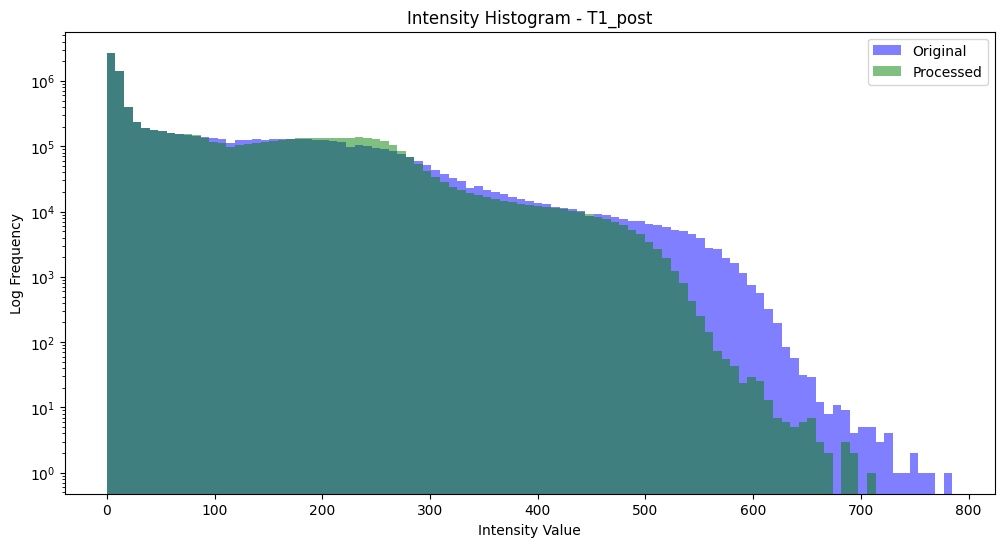

+-----------+-------+--------------------+
|  T1_post  |  Mean | Standard Deviation |
+-----------+-------+--------------------+
|  Original | 89.13 |       110.09       |
| Processed | 88.13 |       105.56       |
+-----------+-------+--------------------+


--- Analysis for T1_pre ---



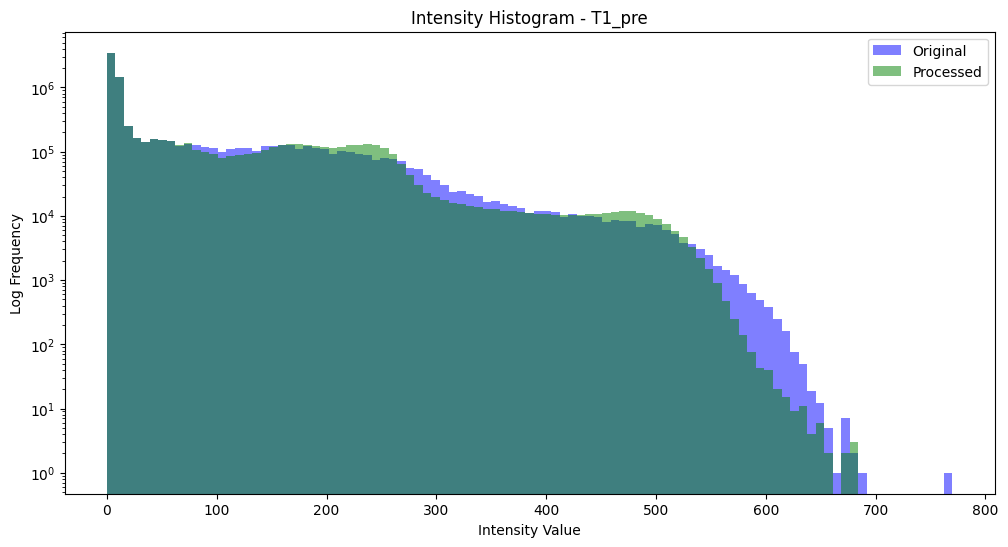

+-----------+-------+--------------------+
|   T1_pre  |  Mean | Standard Deviation |
+-----------+-------+--------------------+
|  Original | 77.79 |       105.53       |
| Processed | 79.17 |       106.34       |
+-----------+-------+--------------------+


--- Analysis for T2 ---



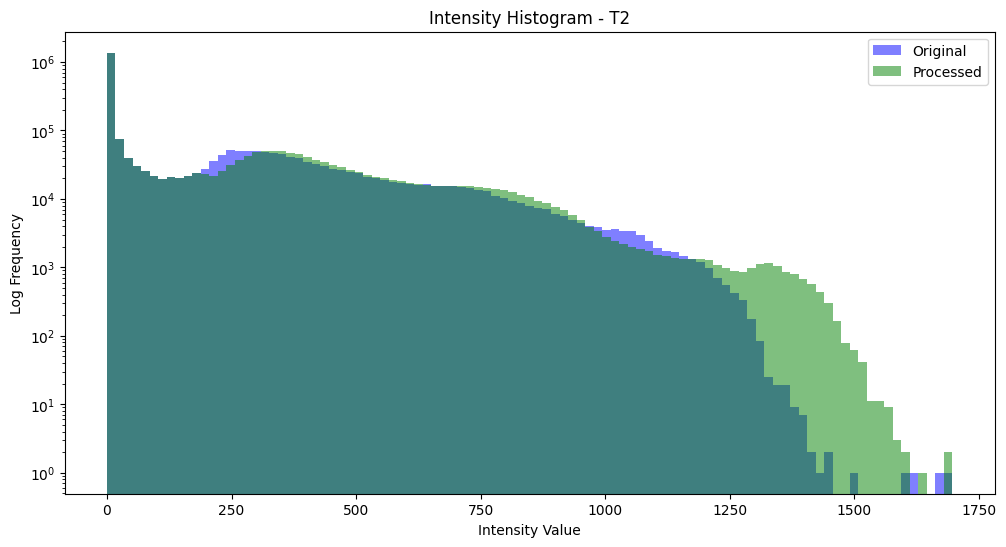

+-----------+--------+--------------------+
|     T2    |  Mean  | Standard Deviation |
+-----------+--------+--------------------+
|  Original | 197.59 |       261.41       |
| Processed | 208.27 |       275.11       |
+-----------+--------+--------------------+


--- Analysis for FLAIR ---



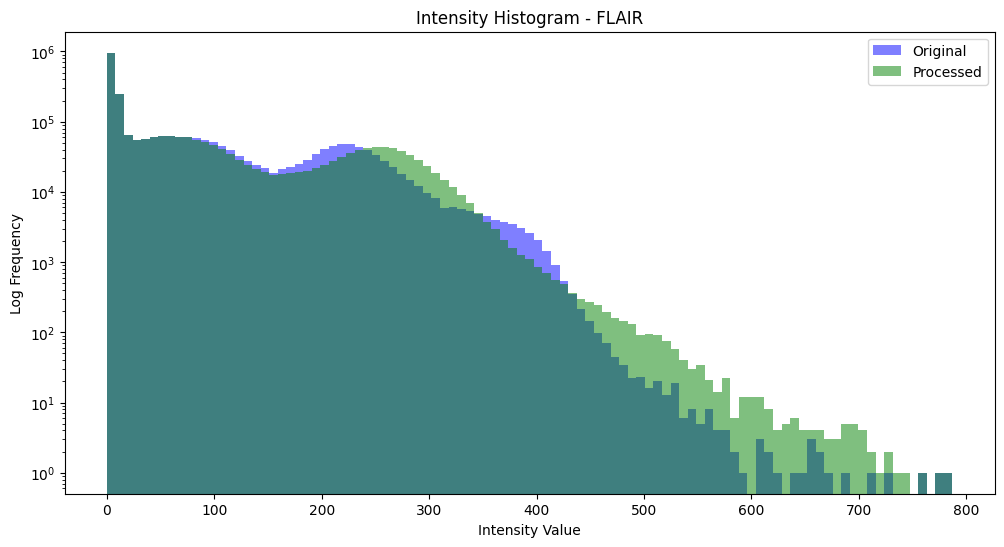

+-----------+-------+--------------------+
|   FLAIR   |  Mean | Standard Deviation |
+-----------+-------+--------------------+
|  Original | 79.90 |       95.78        |
| Processed | 84.78 |       102.53       |
+-----------+-------+--------------------+




In [4]:
import matplotlib.pyplot as plt
from prettytable import PrettyTable

def plot_histograms(original, processed, title):
    plt.figure(figsize=(12, 6))
    
    # Calculate bins from the combined range of both images
    combined_min = min(original.min(), processed.min())
    combined_max = max(original.max(), processed.max())
    bins = np.linspace(combined_min, combined_max, num=100)
    
    # Plot original histogram using a log scale if needed
    plt.hist(original.flatten(), bins=bins, alpha=0.5, label='Original', color='blue', log=True)
    
    # Plot processed histogram using the same bins and log scale
    plt.hist(processed.flatten(), bins=bins, alpha=0.5, label='Processed', color='green', log=True)
    
    plt.title(f'Intensity Histogram - {title}')
    plt.xlabel('Intensity Value')
    plt.ylabel('Log Frequency')
    plt.legend()
    plt.show()


def display_stats_table(original, processed, title):
    table = PrettyTable()
    table.field_names = [f"{title}", "Mean", "Standard Deviation"]
    table.add_row(["Original", f"{np.mean(original):.2f}", f"{np.std(original):.2f}"])
    table.add_row(["Processed", f"{np.mean(processed):.2f}", f"{np.std(processed):.2f}"])
    print(table)

# Function to execute the plotting and analysis for each sequence
def analyze_sequence(img, processed_img, title):
    print(f"--- Analysis for {title} ---\n")
    plot_histograms(img, processed_img, title)
    display_stats_table(img, processed_img, title)
    print("\n")

# Executing analysis for each sequence
analyze_sequence(t1_post_img, t1_post_processed, 'T1_post')
analyze_sequence(t1_pre_img, t1_pre_processed, 'T1_pre')
analyze_sequence(t2_img, t2_processed, 'T2')
analyze_sequence(flair_img, flair_processed, 'FLAIR')
